<a href="https://colab.research.google.com/github/Abdul-Moeed/headline-gen-metrics/blob/master/rouge_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPT-2
This notebook goes through the process from generating headlines to evaluating them with GPT-2

### Preparing environment

In [0]:
# import google drive access
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
cd /content/gdrive/'My Drive'/GPT-2

/content/gdrive/My Drive/GPT-2


In [0]:
cd gpt2

/content/gdrive/My Drive/GPT-2/gpt2


In [0]:
!pip install py-rouge

     |████████████████████████████████| 61kB 3.8MB/s 


In [0]:
!pip install nltk

In [0]:
import json
import gzip
import math
import numpy as np
import pandas as pd
from utils import getDF
from pickle import load
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import os
import re
import seaborn as sns
import rouge
from utils import create_list, angular_similarity, frechet_distance

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
# Load Data
with open('samples.json', 'r') as read_file:
  data = json.load(read_file)
  
#generated, summary, review = create_list(data)

In [0]:
generated = [] # generated
summary = [] # ground truth
review = []

for key in data:
  summary_text = data[key]['summary'][:-1].strip()
  generated_text = data[key]['generated'][0].strip()
  
  if summary_text != generated_text:
    review.append(data[key]['reviewText'][:-7])
    summary.append(summary_text)
    generated.append(generated_text)
  else:
    print(summary_text, " | ", generated_text)


In [0]:
generated = generated[:20]
summary = summary[:20]
review = review[:20]

### Angular Similarity

In [0]:
# individual angular similarity calculation
ang_sim_gen_gt = []
ang_sim_gen_text = []
ang_sim_gt_text = []
for i in range(len(generated)):
  gen = np.expand_dims(generated_embeddings[i], axis=0)
  summary = np.expand_dims(summary_embeddings[i], axis=0)
  review = np.expand_dims(review_embeddings[i], axis=0)
  
  ang_sim_gen_gt.append(float(angular_similarity(gen, summary)[0]))
  ang_sim_gen_text.append(float(angular_similarity(gen, review)[0]))
  ang_sim_gt_text.append(float(angular_similarity(summary, review)[0]))

In [0]:
# save these to json file
scores = {}
scores['Newsroom'] = {'gen_gt': ang_sim_gen_gt,
                   'gen_text': ang_sim_gen_text,
                   'gt_text': ang_sim_gt_text}
with open('angular.json', 'a') as outfile:
  json.dump(scores, outfile)

In [0]:
angular_generated_summary = angular_similarity(generated_embeddings, summary_embeddings)
angular_generated_review = angular_similarity(generated_embeddings, review_embeddings)
angular_summary_review = angular_similarity(summary_embeddings, review_embeddings)

0.6903917


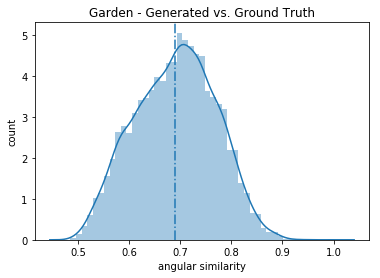

In [0]:
print(angular_generated_summary.mean())
sns.distplot(angular_generated_summary)
plt.xlabel('angular similarity')
plt.ylabel('count')
plt.title('Garden - Generated vs. Ground Truth')
plt.axvline(angular_generated_summary.mean(),linestyle='-.')

0.70064783


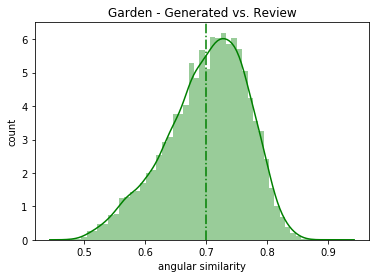

In [0]:
print(angular_generated_review.mean())
sns.distplot(angular_generated_review,color='g')
plt.xlabel('angular similarity')
plt.ylabel('count')
plt.title('Garden - Generated vs. Review')
plt.axvline(angular_generated_review.mean(),linestyle='-.',color='g')

0.7161089


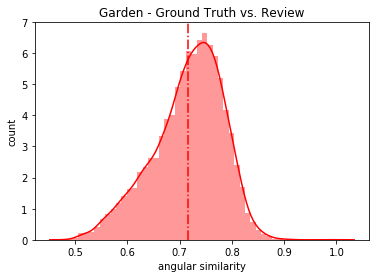

In [0]:
print(angular_summary_review.mean())
sns.distplot(angular_summary_review,color='r')
plt.xlabel('angular similarity')
plt.ylabel('count')
plt.title('Garden - Ground Truth vs. Review')
plt.axvline(angular_summary_review.mean(),linestyle='-.',color='r')

### ROUGE

In [0]:
def get_samples(name):
  with open(name, 'r') as read_file:
    data = json.load(read_file)

  generated = [] # generated
  summary = [] # ground truth
  review = []

  for key in data:
    summary_text = data[key]['summary'][:-1].strip()
    generated_text = data[key]['generated'][0].strip()
    
    if summary_text != generated_text:
      review.append(data[key]['reviewText'][:-7])
      summary.append(summary_text)
      generated.append(generated_text)
    else:
      print(summary_text, " | ", generated_text)

  generated = generated[:20]
  summary = summary[:20]
  review = review[:20]

  return generated, summary, review

In [0]:
def get_f_score(data):
  result = dict()
  for key, value in data.items():
    result[key] = value[0]['f'][0]
  
  return result

In [0]:
def get_rouge_scores(generated, summary, review, evaluator):
  gen_gt = []
  gen_text = []
  gt_text = []

  for gen, summ, rev in zip(generated, summary, review):
    gen_gt.append(get_f_score(evaluator.get_scores(gen, summ)))
    gen_text.append(get_f_score(evaluator.get_scores(gen, rev)))
    gt_text.append(get_f_score(evaluator.get_scores(summ, rev)))
  
  return gen_gt, gen_text, gt_text

In [0]:
evaluator = rouge.Rouge(metrics=['rouge-n', 'rouge-l'],
                       max_n=2,
                       limit_length=False,
                       length_limit=1000,
                       length_limit_type='words',
                       apply_avg=False,
                       apply_best=False,
                       alpha=0.5, # Default F1_score
                       weight_factor=1.2,
                       stemming=True)

In [0]:
datasets = ["samples.json", "samples_cnn-dm.json", "samples-newsroom.json", "samples-gigaword.json"]
rouge_scores = []
for dataset in datasets:
  generated, summary, review = get_samples(dataset)
  gen_gt, gen_text, gt_text = get_rouge_scores(generated, summary, review, evaluator)
  rouge_scores.append({"gen_gt": gen_gt,
                         "gen_text": gen_text,
                         "gt_text": gt_text})
with open('rouge_f_scores.json', 'w') as outfile:
  json.dump(rouge_scores, outfile)


This page includes the show Transcript  |  This page includes the show Transcript
coulthard wins monaco grand prix  |  coulthard wins monaco grand prix
dollar at ###.##-## yen in early tokyo trade  |  dollar at ###.##-## yen in early tokyo trade
hong kong gold opens lower  |  hong kong gold opens lower
hong kong shares open slightly lower  |  hong kong shares open slightly lower
jakarta shares close fractionally higher  |  jakarta shares close fractionally higher
hong kong gold opens higher  |  hong kong gold opens higher
new zealand stocks close #.# percent firmer  |  new zealand stocks close #.# percent firmer
modahl retires from athletics  |  modahl retires from athletics
hong kong gold closes higher  |  hong kong gold closes higher
malaysian shares close #.# percent lower  |  malaysian shares close #.# percent lower
malaysian shares close #.# percent lower  |  malaysian shares close #.# percent lower
palestinian police fire on israeli car  |  palestinian police fire on israeli car


In [0]:
'''
dataset = "Amazon"
rouge_scores = dict()
rouge_scores[dataset] = {"gen_gt": gen_gt,
                         "gen_text": gen_text,
                         "gt_text": gt_text}
with open('rouge.json', 'w') as outfile:
  json.dump(rouge_scores, outfile)
'''

In [0]:
def calc_mean_scores(data):
  r1_f, r2_f, rl_f, rw_f = [], [], [], []
  r1_p, r2_p, rl_p, rw_p = [], [], [], []
  r1_r, r2_r, rl_r, rw_r = [], [], [], []
  for item in data:
    r1_f.append(item['rouge-1'][0]['f'][0])
    r1_p.append(item['rouge-1'][0]['p'][0])
    r1_r.append(item['rouge-1'][0]['r'][0])

    r2_f.append(item['rouge-2'][0]['f'][0])
    r2_p.append(item['rouge-2'][0]['p'][0])
    r2_r.append(item['rouge-2'][0]['r'][0])

    rl_f.append(item['rouge-l'][0]['f'][0])
    rl_p.append(item['rouge-l'][0]['p'][0])
    rl_r.append(item['rouge-l'][0]['r'][0])

    rw_f.append(item['rouge-w'][0]['f'][0])
    rw_p.append(item['rouge-w'][0]['p'][0])
    rw_r.append(item['rouge-w'][0]['r'][0])

  r1_f = sum(r1_f)/float(len(r1_f))
  r2_f = sum(r2_f)/float(len(r2_f))
  rl_f = sum(rl_f)/float(len(rl_f))
  rw_f = sum(rw_f)/float(len(rw_f))

  r1_p = sum(r1_p)/float(len(r1_p))
  r2_p = sum(r2_p)/float(len(r2_p))
  rl_p = sum(rl_p)/float(len(rl_p))
  rw_p = sum(rw_p)/float(len(rw_p))

  r1_r = sum(r1_r)/float(len(r1_r))
  r2_r = sum(r2_r)/float(len(r2_r))
  rl_r = sum(rl_r)/float(len(rl_r))
  rw_r = sum(rw_r)/float(len(rw_r))

  return r1_f, r2_f, rl_f, rw_f, r1_p, r2_p, rl_p, rw_p, r1_r, r2_r, rl_r, rw_r

In [0]:
# calculate avg rouge on dataset
rouge_mean = dict()
rouge_mean[dataset] = {"gen_gt": {"r1": {"f": 0, "p": 0, "r": 0},
                                  "r2": {"f": 0, "p": 0, "r": 0},
                                  "rl": {"f": 0, "p": 0, "r": 0},
                                  "rw": {"f": 0, "p": 0, "r": 0}},
                       "gen_text": {"r1": {"f": 0, "p": 0, "r": 0},
                                  "r2": {"f": 0, "p": 0, "r": 0},
                                  "rl": {"f": 0, "p": 0, "r": 0},
                                  "rw": {"f": 0, "p": 0, "r": 0}},
                       "gt_text": {"r1": {"f": 0, "p": 0, "r": 0},
                                  "r2": {"f": 0, "p": 0, "r": 0},
                                  "rl": {"f": 0, "p": 0, "r": 0},
                                  "rw": {"f": 0, "p": 0, "r": 0}}}
for idx, l in enumerate((gen_gt, gen_text, gt_text)):
  if idx == 0:
    l_type = "gen_gt"
  elif idx == 1:
    l_type = "gen_text"
  else:
    l_type = "gt_text"
    
  r1_f, r2_f, rl_f, rw_f, r1_p, r2_p, rl_p, rw_p, r1_r, r2_r, rl_r, rw_r = calc_mean_scores(l)
  rouge_mean[dataset][l_type]["r1"]["f"] = r1_f
  rouge_mean[dataset][l_type]["r2"]["f"] = r2_f
  rouge_mean[dataset][l_type]["rl"]["f"] = rl_f
  rouge_mean[dataset][l_type]["rw"]["f"] = rw_f
  
  rouge_mean[dataset][l_type]["r1"]["r"] = r1_r
  rouge_mean[dataset][l_type]["r2"]["r"] = r2_r
  rouge_mean[dataset][l_type]["rl"]["r"] = rl_r
  rouge_mean[dataset][l_type]["rw"]["r"] = rw_r
  
  rouge_mean[dataset][l_type]["r1"]["p"] = r1_p
  rouge_mean[dataset][l_type]["r2"]["p"] = r2_p
  rouge_mean[dataset][l_type]["rl"]["p"] = rl_p
  rouge_mean[dataset][l_type]["rw"]["p"] = rw_p
with open('rouge_mean_scores.json', 'a') as outfile:
  json.dump(rouge_mean, outfile)

In [0]:
rouge_mean

{'Newsroom': {'gen_gt': {'r1': {'f': 0.16052275443558012,
    'p': 0.16030814628144052,
    'r': 0.17912254272753442},
   'r2': {'f': 0.04464684679527587,
    'p': 0.04470936912627627,
    'r': 0.051521665694367606},
   'rl': {'f': 0.18590965203415097,
    'p': 0.18425884122266198,
    'r': 0.20276836197974335},
   'rw': {'f': 0.10982962570912899,
    'p': 0.1379572412364323,
    'r': 0.10162035574206267}},
  'gen_text': {'r1': {'f': 0.11054784810450792,
    'p': 0.5110575785892935,
    'r': 0.06520525400788767},
   'r2': {'f': 0.03155946227363776,
    'p': 0.15548624885885584,
    'r': 0.01848581886960252},
   'rl': {'f': 0.13575037965206382,
    'p': 0.47296264135591837,
    'r': 0.08289113082896829},
   'rw': {'f': 0.03510495699998911,
    'p': 0.3538852703053136,
    'r': 0.01920173980458071}},
  'gt_text': {'r1': {'f': 0.12428620381706026,
    'p': 0.6106625087315227,
    'r': 0.0730630315591771},
   'r2': {'f': 0.05315383246765315,
    'p': 0.2591375339182323,
    'r': 0.03175599